In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Lead Scoring.csv')

In [3]:
# Drop duplicate rows and rows with any missing values
df = df.drop_duplicates().dropna()

In [4]:
# Verify that duplicates and missing values are removed
print("Number of duplicate rows:", df.duplicated().sum())
print("Number of missing values:", df.isnull().sum().sum())

Number of duplicate rows: 0
Number of missing values: 0


In [5]:
# Drop columns with a high percentage of missing values
df = df.dropna(thresh=len(df) * 0.6, axis=1)  # Drops columns with >60% missing values

In [6]:
# Fill missing numerical values with the mean
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

C:\Users\aarya\AppData\Local\Temp\ipykernel_11604\2245301924.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [7]:
# Fill missing categorical values with the mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

C:\Users\aarya\AppData\Local\Temp\ipykernel_11604\1712366260.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [8]:
# Use one-hot encoding for categorical columns
df = pd.get_dummies(df, drop_first=True)

In [9]:
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [10]:
# Check unique values in the target column
print("Unique values in the target column 'Converted':", df['Converted'].unique())

# Convert 'Converted' to binary if it has continuous or unexpected values
# (Adjust threshold if needed)
df['Converted'] = (df['Converted'] > 0.5).astype(int)

Unique values in the target column 'Converted': [ 0.92988349 -1.07540355]


In [11]:
X = df.drop('Converted', axis=1)  # Features
y = df['Converted']              # Target variable

In [12]:
# Save Lead_Name column (or equivalent) if it exists
lead_names = df.get('Lead_Name', pd.Series(range(len(df))))  # Use index as fallback

In [13]:
# Define features and target
X = df.drop(columns=['Converted'])
y = df['Converted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Initialize XGBoost Classifier
model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [15]:
y_pred = model.predict(X_test)

In [16]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9562982005141388
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       172
           1       0.96      0.96      0.96       217

    accuracy                           0.96       389
   macro avg       0.96      0.96      0.96       389
weighted avg       0.96      0.96      0.96       389



In [17]:
# Get probability scores for each lead
lead_scores = model.predict_proba(X_test)[:, 1]  # Probability of being in the positive class (conversion)

In [18]:
# Add lead scores to a DataFrame for better visualization
lead_scores_df = pd.DataFrame({
    'Lead_ID': X_test.index,
    'Lead_Score': lead_scores
})


In [19]:
# Sort leads by score (descending)
lead_scores_df = lead_scores_df.sort_values(by='Lead_Score', ascending=False)
print(lead_scores_df.head())

     Lead_ID  Lead_Score
251     1026    0.999572
226      964    0.999520
136     7420    0.999383
159      686    0.999353
386     1190    0.999338


In [20]:
# Smaller parameter grid for faster performance
param_grid = {
    'max_depth': [3, 5],  # Reduced values
    'learning_rate': [0.01, 0.1],  # Reduced values
    'n_estimators': [100, 200],  # Reduced values
    'subsample': [0.8, 1.0]
}

In [21]:
# Use n_jobs=-1 to utilize all cores
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 2 folds for each of 16 candidates, totalling 32 fits


<Figure size 1200x800 with 0 Axes>

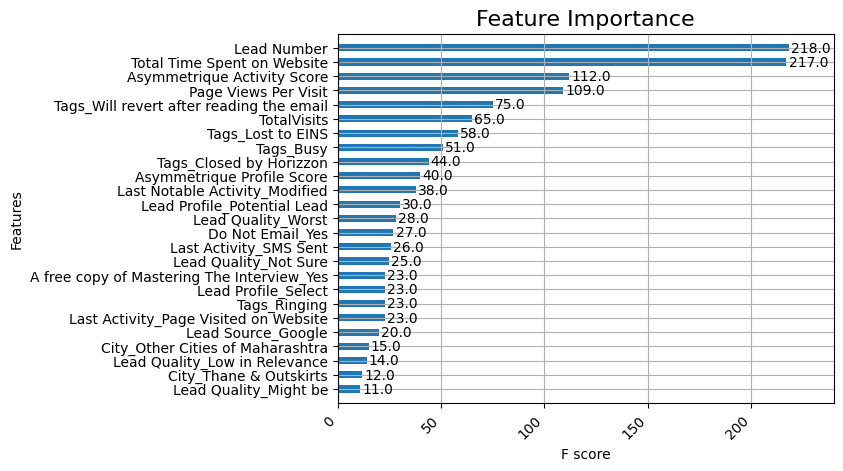

In [22]:
# Plot importance with adjustments
plt.figure(figsize=(12, 8))  # Increase figure size for better readability
xgb.plot_importance(
    model,
    importance_type='weight',  # You can change 'weight' to 'gain' or 'cover' if you prefer
    max_num_features=25,  # Show only top 20 features
    height=0.5  # Adjust bar height for better spacing
)
plt.title('Feature Importance', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better clarity
plt.show()

In [23]:
# Function for predicting lead scores based on user input
def predict_lead_score(input_data):
     # Convert input dictionary to DataFrame
    input_df = pd.DataFrame([input_data])
    input_df = pd.get_dummies(input_df, drop_first=True)
    
    # Align input_df with training data's feature set
    missing_cols = set(X.columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 0  # Add missing columns with default value 0
    input_df = input_df[X.columns]  # Ensure correct column order
    
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])
    
    
# Predict lead score
    score = best_model.predict_proba(input_df)[:, 1][0]
    return score